#HOMEWORK_2


IMPORTING LIBRARIES

In [0]:

%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform


print("Tensorflow version %s" %tf.version)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Using TensorFlow backend.


Tensorflow version <module 'tensorflow._api.v1.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow_core/_api/v1/version/__init__.py'>
Found GPU at: /device:GPU:0


In [0]:
import random
import numpy as np
import keras
import sklearn.metrics 
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['HAZE', 'RAINY', 'SNOWY', 'SUNNY']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import drive


datadir = '/content/drive/My Drive'
trainingset = datadir + '/training_set/'
testset = datadir + '/test_set/'
blind_test = datadir + '/BlindTestSet/'


batch_size = 32
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_blind_datagen = ImageDataGenerator(
    rescale = 1. / 255)


test_blind_generator = test_blind_datagen.flow_from_directory(
    directory=blind_test,
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))
print('Loaded %d test samples.' %(test_blind_generator.n))

Found 3619 images belonging to 4 classes.
Found 410 images belonging to 4 classes.
Found 1500 images belonging to 1 classes.
Image input (128, 128, 3)
Classes: ['HAZE', 'RAINY', 'SNOWY', 'SUNNY']
Loaded 3619 training samples from 4 classes.
Loaded 410 test samples from 4 classes.
Loaded 1500 test samples.


ALEX-NET MODEL

In [0]:
import keras
from keras.models import *
from keras.layers import *
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers
from keras import initializers
from keras import utils


import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform

def build_alexNet_model(input_shape, num_classes):
	regl2 = 0.0001    
	lr = 0.0001
	model = Sequential()
	# C1 Convolutional Layer 
	model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11),\
					 strides=(2,4), padding='valid'))
	model.add(Activation('relu'))
	# Pooling
	model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
	# Batch Normalisation before passing it to the next layer
	model.add(BatchNormalization())
	# C2 Convolutional Layer
	model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
	model.add(Activation('relu'))
	# Pooling
	model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
	# Batch Normalisation
	model.add(BatchNormalization())
	# C3 Convolutional Layer
	model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
	model.add(Activation('relu'))
	# Batch Normalisation
	model.add(BatchNormalization())
	# C4 Convolutional Layer
	model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
	model.add(Activation('relu'))
	# Batch Normalisation
	model.add(BatchNormalization())
	# C5 Convolutional Layer
	model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
	model.add(Activation('relu'))
	# Pooling
	model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
	# Batch Normalisation
	model.add(BatchNormalization())
	# Flatten
	model.add(Flatten())
	flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
	# D1 Dense Layer
	model.add(Dense(4096, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
	model.add(Activation('relu'))
	# Dropout
	model.add(Dropout(0.4))
	# Batch Normalisation
	model.add(BatchNormalization())
	# D2 Dense Layer
	model.add(Dense(4096, kernel_regularizer=regularizers.l2(regl2)))
	model.add(Activation('relu'))
	# Dropout
	model.add(Dropout(0.4))
	# Batch Normalisation
	model.add(BatchNormalization())
	# D3 Dense Layer
	model.add(Dense(1000,kernel_regularizer=regularizers.l2(regl2)))
	model.add(Activation('relu'))
	# Dropout
	model.add(Dropout(0.4))
	# Batch Normalisation
	model.add(BatchNormalization())
	# Output Layer
	model.add(Dense(num_classes))
	model.add(Activation('softmax'))
	# Compile
	adam = optimizers.Adam(lr=lr)
	model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])    
	model.summary()
	return model
 
# create the model
model = build_alexNet_model(input_shape,num_classes)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 59, 30, 96)        34944     
_________________________________________________________________
activation_24 (Activation)   (None, 59, 30, 96)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 29, 15, 96)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 29, 15, 96)        384       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 19, 5, 256)        2973952   
_________________________________________________________________
activation_25 (Activation)   (None, 19, 5, 256)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 2, 256)        

MODEL RESNET

In [0]:

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """ 
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the input value. You'll need this later to add back to the main path. 
    ## Perform convolution + batch norm operations on X
    X_shortcut = X
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    ### START CODE HERE ###
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    ### END CODE HERE ###  
    return X
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the input value
    X_shortcut = X
    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)    
    ### START CODE HERE ###
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f,f), strides = (1,1), padding='same',name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)    
    ### END CODE HERE ###   
    return X
def build_ResNet50_model(input_shape, num_classes):  
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)   
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)
    # Output layer
    X = Flatten()(X)
    X = Dense(num_classes, activation='softmax', name='fc' + str(num_classes), kernel_initializer = glorot_uniform(seed=0))(X)
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_ResNet50_model(input_shape,num_classes)
model.summary()
















Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
____________________________________________________________________________

OTHER MODEL

In [0]:
from keras import optimizers
def build_model_1(input_shape, num_classes):
  regl2 = 0.0001    
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(512, kernel_regularizer=regularizers.l2(regl2)))  #the regularizers.l2(regl2) is used to avoid overfitting
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='sigmoid'))
  model.compile(optimizers.SGD(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=["accuracy"])
  model.summary()
  return model

model = build_model_1(input_shape,num_classes)
model.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
activation_13 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_14 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 63, 63, 64)     

FIT THE MODEL

In [0]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

try:
    history = model.fit_generator(train_generator, epochs=80, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/80
 20/113 [====>.........................] - ETA: 1:32 - loss: 2.2981 - acc: 0.4297

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


 45/113 [==========>...................] - ETA: 54s - loss: 2.1448 - acc: 0.4965

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


 56/113 [=============>................] - ETA: 44s - loss: 2.1102 - acc: 0.5156

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 76/113 [===================>..........] - ETA: 27s - loss: 2.0485 - acc: 0.5358

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


113/113 [==============================] - 84s 742ms/step - loss: 1.9964 - acc: 0.5571 - val_loss: 4.7530 - val_acc: 0.2951
Epoch 2/80
113/113 [==============================] - 81s 716ms/step - loss: 1.7924 - acc: 0.6182 - val_loss: 6.0859 - val_acc: 0.2976
Epoch 3/80
113/113 [==============================] - 81s 718ms/step - loss: 1.8210 - acc: 0.6035 - val_loss: 3.3019 - val_acc: 0.4537
Epoch 4/80
113/113 [==============================] - 81s 715ms/step - loss: 1.7999 - acc: 0.6240 - val_loss: 1.8459 - val_acc: 0.6390
Epoch 5/80
113/113 [==============================] - 82s 723ms/step - loss: 1.7354 - acc: 0.6385 - val_loss: 1.9233 - val_acc: 0.6098
Epoch 6/80
113/113 [==============================] - 75s 662ms/step - loss: 1.6689 - acc: 0.6516 - val_loss: 2.3249 - val_acc: 0.4854
Epoch 7/80
113/113 [==============================] - 71s 631ms/step - loss: 1.6266 - acc: 0.6666 - val_loss: 2.2217 - val_acc: 0.5000
Epoch 8/80
113/113 [==============================] - 77s 684ms/st

SAVE THE MODEL


In [0]:
import os
from keras.models import load_model

models_dir = datadir

def loadmodel(problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    try:
        model = load_model(filename)
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:    
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    return model

model = loadmodel('mymodel_imagesclassification_resnet')
















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Model loaded successfully from file /content/drive/My Drive/mymodel_imagesclassification_resnet.h5



In [0]:
import os
import csv
models_dir = datadir

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

# Save the model
#savemodel(model,'mymodel_imagesclassification_alexnet')


val_steps=test_blind_generator.n//test_blind_generator.batch_size+1
preds_blind = model.predict_generator(test_blind_generator,verbose=1,steps=val_steps)

Ypred_blind = np.argmax(preds_blind, axis=1)

print(Ypred_blind)

with open('/content/drive/My Drive/1707633.csv', mode='w') as csv_file:
    fieldnames = ['Classes']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    i=0
    var = ""
    while i<len(Ypred_blind):
      if(Ypred_blind[i] == 0):
        var = "HAZE"
      elif(Ypred_blind[i] == 1):
        var = "RAINY"
      elif(Ypred_blind[i] == 2):
        var = "SNOWY"
      else:
        var = "SUNNY"
    
      writer.writerow({'Classes': var})
      i+=1


47/47 [==============================] - 22s 462ms/step
[3 3 3 ... 3 0 0]


EVALUATION

Found 410 images belonging to 4 classes.
13/13 [==============================] - 8s 609ms/step
Test loss: 1.523722
Test accuracy: 0.668293
13/13 [==============================] - 9s 655ms/step
              precision    recall  f1-score   support

        HAZE      0.889     0.320     0.471       100
       RAINY      0.907     0.490     0.636       100
       SNOWY      0.527     0.882     0.660       110
       SUNNY      0.706     0.960     0.814       100

    accuracy                          0.668       410
   macro avg      0.757     0.663     0.645       410
weighted avg      0.752     0.668     0.645       410

Found 410 images belonging to 4 classes.
13/13 [==============================] - 7s 576ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
HAZE             ->  SNOWY             	50 	12.20 % 
RAINY            ->  SNOWY             	34 	8.29 % 
RAINY            ->  SUNNY             	15 	3.6

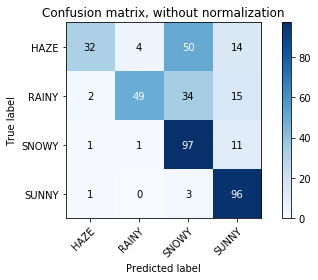

In [0]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)
val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = model.evaluate_generator(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)


preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

val_steps=test_generator.n//test_generator.batch_size+1



test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

plot_confusion_matrix(Ytest, Ypred, classes=['HAZE','RAINY','SUNNY','SNOWY'], normalize=False)


RESULTS

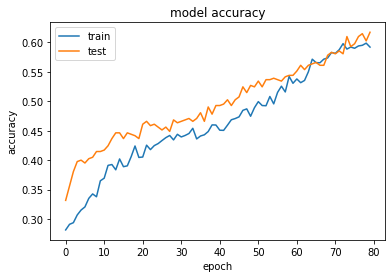

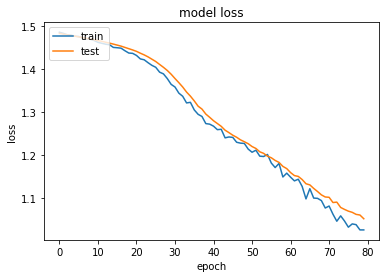

In [0]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()